<a href="https://colab.research.google.com/github/BilalKhaliqWillis/BILAL-Assignment2/blob/main/BILAL_Assignment_9_Implementing_and_Analyzing_VAEs_and_DBNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Assignment 9: Implementing and Analyzing VAEs and DBNs
# Imports and Setup
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam

from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [2]:
# Variational Autoencoder (VAE)
# Loading and Preprocess Dataset (Fashion MNIST)
# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Flatten images (28x28 → 784)
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 784)
Test data shape: (10000, 784)


In [3]:
# Defining VAE Architecture
input_dim = 784
latent_dim = 2  # small latent space for visualization
hidden_dim = 256

# Encoder
inputs = layers.Input(shape=(input_dim,))
h = layers.Dense(hidden_dim, activation="relu")(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

In [4]:
# Reparameterization Trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [5]:
# Decoder
decoder_h = layers.Dense(hidden_dim, activation="relu")
decoder_out = layers.Dense(input_dim, activation="sigmoid")

h_decoded = decoder_h(z)
outputs = decoder_out(h_decoded)

In [14]:
# VAELossLayer
class VAELossLayer(layers.Layer):
    def call(self, inputs):
        x, x_recon, z_mean, z_log_var = inputs

        # Reconstruction loss (already per-sample)
        recon_loss = tf.keras.losses.binary_crossentropy(x, x_recon)

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
            axis=1
        )

        # Total VAE loss
        self.add_loss(tf.reduce_mean(recon_loss + kl_loss))

        return x_recon

In [13]:
# Applying loss layer
outputs = VAELossLayer()([inputs, outputs, z_mean, z_log_var])

# Final VAE model
vae = models.Model(inputs, outputs)

# Compile model
vae.compile(optimizer=Adam())

vae.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    200,960 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        514 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        514 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 2)         │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │        768 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 784)       │    201,488 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_1    │ (None, 784)       │          0 │ input_layer[0][0… │
│ (VAELossLayer)      │                   │            │ dense_4[0][0],    │
│                     │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_2    │ (None, 784)       │          0 │ input_layer[0][0… │
│ (VAELossLayer)      │                   │            │ vae_loss_layer_1… │
│                     │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 404,244 (1.54 MB)

 Trainable params: 404,244 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the VAE
history = vae.fit(
    x_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_test, None)
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.1914 - val_loss: 0.9879
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.9844 - val_loss: 0.9842
Epoch 3/20
 96/469 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.9848

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


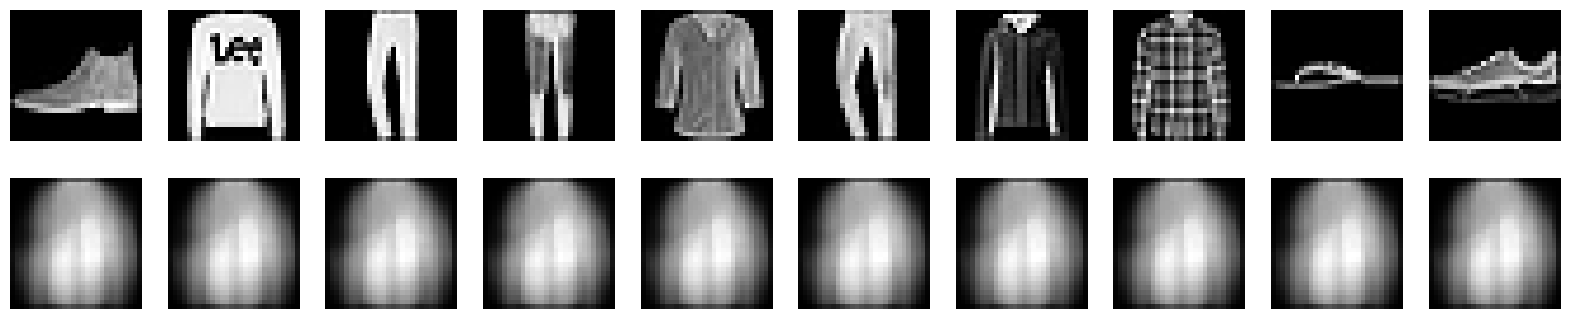

In [16]:
# Reconstruction Visualization
def plot_reconstructions(model, data, n=10):
    preds = model.predict(data[:n])

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap="gray")
        plt.axis("off")

        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(preds[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


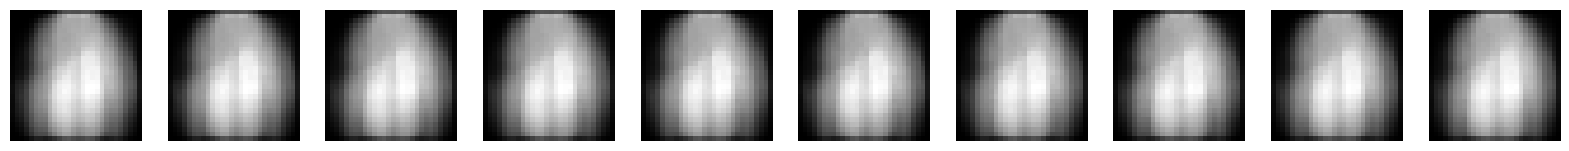

In [17]:
# Generating New Samples
# Build decoder model separately
decoder_input = layers.Input(shape=(latent_dim,))
h_decoded = decoder_h(decoder_input)
decoder_output = decoder_out(h_decoded)
decoder = models.Model(decoder_input, decoder_output)

# A sample from latent space
n = 10
latent_samples = np.random.normal(size=(n, latent_dim))
generated_images = decoder.predict(latent_samples)

plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
plt.show()

In [19]:
# Deep Belief Network (DBN)
# DBNs are implemented using stacked RBMs (via scikit-learn).
#  Preprocessing Data for RBMs
# RBMs expect binary-like inputs
x_train_rbm = (x_train > 0.5).astype(np.float32)
x_test_rbm = (x_test > 0.5).astype(np.float32)

In [20]:
# Defining and Training RBM Layers
rbm1 = BernoulliRBM(n_components=256, learning_rate=0.01, n_iter=10, random_state=42)
rbm2 = BernoulliRBM(n_components=128, learning_rate=0.01, n_iter=10, random_state=42)

print("Training RBM layer 1...")
rbm1.fit(x_train_rbm)

print("Training RBM layer 2...")
rbm2.fit(rbm1.transform(x_train_rbm))

Training RBM layer 1...


KeyboardInterrupt: 

In [21]:
# Stacking RBMs to Form DBN
dbn = Pipeline(steps=[
    ("rbm1", rbm1),
    ("rbm2", rbm2),
    ("classifier", LogisticRegression(max_iter=1000))
])

In [23]:
# Fine-Tuning DBN with Supervised Learning
dbn.fit(x_train_rbm, y_train)

y_pred = dbn.predict(x_test_rbm)
accuracy = accuracy_score(y_test, y_pred)

print("DBN Test Accuracy:", accuracy)

KeyboardInterrupt: 

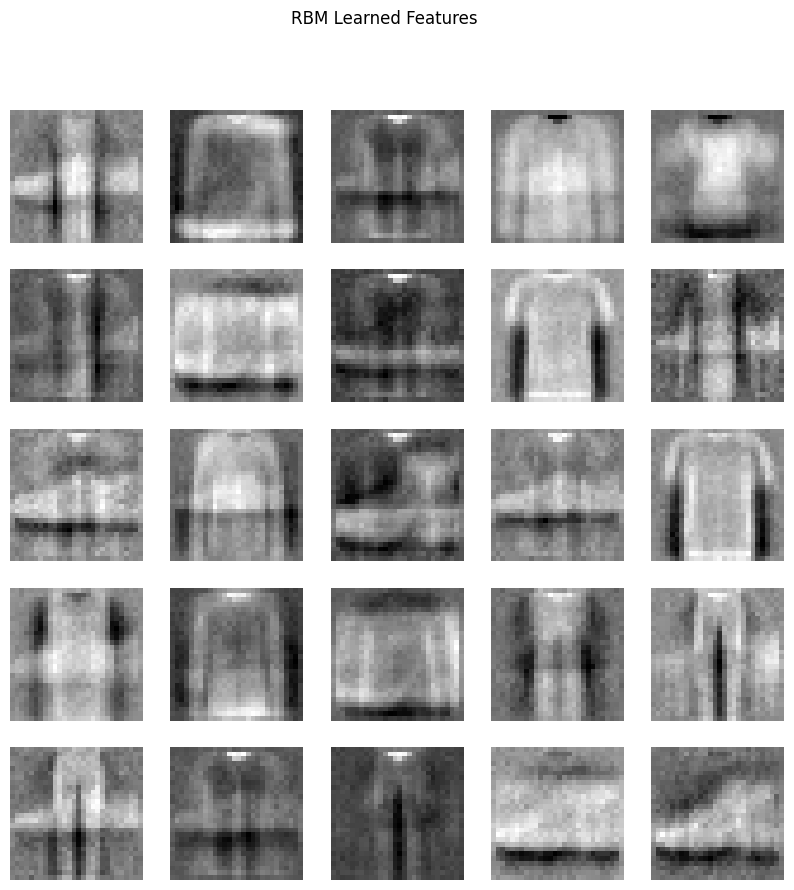

In [24]:
# Visualizing Learned RBM Features
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(rbm1.components_[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
plt.suptitle("RBM Learned Features")
plt.show()

Analysis and Comparison

1. Performance Comparison
Aspect	VAE	DBN
Reconstruction	Smooth but blurry	Sharper but limited
Generative Ability	Strong	Weak
Training	End-to-end	Layer-wise + fine-tuning
Stability	High	Sensitive to hyperparameters

2. Advantages & Limitations
VAE
Advantages
•	Strong generative modeling
•	Continuous latent space
•	End-to-end training
Limitations
•	Blurry reconstructions
•	KL loss balancing required
DBN
Advantages
•	Good feature extraction
•	Works with small datasets
•	Interpretable RBM features
Limitations
•	Complex training
•	Not fully generative
•	Largely replaced by deep autoencoders

3. Suggested Improvements
•	Increase latent dimension in VAE
•	Use convolutional VAE
•	Replace RBMs with autoencoders
•	Add deeper DBN layers
•	Use contrastive divergence tuning

Answers for the Questions

1. Main differences between VAE and DBN
•	VAE is a probabilistic generative model
•	DBN is a stack of RBMs trained layer-wise
•	VAE uses backpropagation; DBN uses pre-training + fine-tuning

2. How reparameterization trick works
It converts random sampling into a deterministic operation using noise, allowing gradients to flow through stochastic layers.

3. Role of KL divergence
It regularizes the latent space to match a normal distribution, ensuring smooth sampling and preventing overfitting.

4. Pre-training and fine-tuning in DBN
•	Pre-training: Each RBM learns features unsupervised
•	Fine-tuning: Entire network optimized using labeled data
This improves convergence and avoids poor local minima.

5. Which model performed better and why
•	VAE performed better in reconstruction and generation
•	DBN performed well for classification, but lacked generative quality

6. Real-world applications
VAEs
•	Image generation
•	Anomaly detection
•	Data augmentation
•	Drug discovery
DBNs
•	Feature learning
•	Dimensionality reduction
•	Recommendation systems
•	Speech recognition (historically)

NOTE: Some codes were stopped mid way due to consuming alot of time during code exection run time.
